In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import FreqDist

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score


import xgboost as xgb

from wordcloud import WordCloud

import spacy
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [47]:
#setting some defaults to display 
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500
pd.options.display.max_info_rows = 500
pd.options.display.max_info_columns = 500
pd.options.display.max_colwidth = 200

In [3]:
final_df = pd.read_csv('./datasets/final_df.csv', index_col='date')
final_df.sort_index()
final_df.drop(columns='Unnamed: 0', inplace=True)
final_df.fillna('', inplace=True)

In [4]:
final_df.head()

,open,high,low,close,volume,market_cap,date_stamp,daily_price_diff,pct_change,aantonop,APompliano,brian_armstrong,BitcoinMagazine,CoinDesk,CryptoDonAlt,cz_binance,jimmysong,lopp,PeterLBrandt,PeterSchiff,DoveyWan,real_vijay,rogerkver,saifedean,stephanlivera,winklevoss,VitalikButerin,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,963.66,1003.08,958.70,998.33,147775008,16050407461,2017-01-01,,,everything taste mmmmmm poopic e oxioel going bean went standby reviewpic dp echtvux,,,,,,,,thanks reminder add tried tell people right need tm fixed use segwit hard fork would cleaner happen time soon new new year mbga want understand bitcoin better epic list educational resource sugges...,factormembers robusta wk continuation h lcf fpic ecopyiict,,,,happy new year bitcoin reason excited ever,,,,cat bag taobao ii store mong kok hk prob place know,0
2017-01-02,998.62,1031.39,996.70,1021.75,222184992,16429024775,2017-01-02,23.42,0.0234592,moving house vietnam full size fridge scooter didllmjf,,,icymi op ed new age blockchain entrepreneurship bitcoin fintech tnpwtjwzao bitcoin magazine top business story bitcoin blockchain fintechpic bgfehjvk,,,,,great video added collection mulling back mind quite settled yet tax benefit really want delve detail suggest focusing security model think bitcoin energy expenditure need defended defends also th...,year profitable trade produced holding active trading nice graph dan tell story u middle class living decade actually surprised millennials even guessed well tmoeasgybr db bank forecast usdcnypic ...,,,,,,,,version casper shipping return cost million youlkkk y,0
2017-01-03,1021.60,1044.08,1021.60,1043.84,185168000,16786368910,2017-01-03,22.09,0.0216198,bitcoin q mimblewimble enhance privacy please remove list thank buy v early release oreilly first chapter drafted read come end get full book,,,monero continues upswing kraken launch xmr trading blockchain fintechpic zxo hkpkhw expert predicting bitcoin blockchain tech fintech predictionspic qrqjceqzuw blockchain technology power next gen...,,,,,indeed figure one price pay outspoken must invest resource security lost bitcoins firearm tragic boating accident tell anyone many btc unless trust w life merely mentioning owning btc may make tar...,control whether trade profitable job enter order nothing nothing le bottom platinum place pl f ptm ppltpic gh q l j measure trade whether make money good trade lose money ill conceived trade profi...,investor hoping big gain trump import tax get diminished dollar moawqpqm h podcast tax cut big gov spending economic sedative rather cure,,,built bitcoin original principle privacy decentralization open development scaleability fungibility,,,,usually multiple valley thinking plurality connotation many people almost u political reporting seems trend use describe going nabc sorry probably plane shanghai singapore please stop using word d...,0
2017-01-04,1044.40,1159.42,1044.40,1154.73,344945984,18571869009,2017-01-04,110.89,0.106233,early yes thank think nd edition much improved march ish currently finishing chapter want understand bitcoin matter internet money non technical book wow thanks quote,,,valueshuffle brings together best world bitcoin privacy privacy blockchainpic x pm gyb bot make money lose sleep bitcoin blockchain fintech tradingpic nqdckgfnj,,,,,going live hour w speaking revolutionizing internet architecture well suffice say calculator based upon wtf live hour ago lucky miner txn hash tx creator ask nicely return fee implied bitcoin what...,patience discipline trade well defined geometric price pattern predetermined risk trade mgmt provides trading edge eurocurrency became official jan eurusd e f prior eur plotted based trade weighte...,,,,seen bitcoin reaching time new high unseen high would reached followed satoshi road map,,,,apologizes voting hillary problem bitcoinz without undesirable feature x would longer exist,1
2017-01-05,1156.73,1191.10,910.42,1013.38,510199008,16300254795,2017-01-05,-141.35,-0

In [5]:
# loading NLTK stopwords
stopwords_nltk = set(stopwords.words('english'))

# loading in spacy stopwords
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

for i in stopwords_nltk:
    all_stopwords.add(i)

additional_stop_words = ['twitter', 'pic', 'https', 'com', 'http', 'www', 'bit', 'ly', 'nan']    

for i in additional_stop_words:
    all_stopwords.add(i)

In [6]:
final_df['target'].value_counts()

0    993
1    285
Name: target, dtype: int64

In [7]:
tweet_cols = ['aantonop',
              'APompliano',
              'brian_armstrong',
              'BitcoinMagazine',
              'CoinDesk',
              'CryptoDonAlt',
              'cz_binance',
              'jimmysong',
              'lopp',
              'PeterLBrandt',
              'PeterSchiff',
              'DoveyWan',
              'real_vijay',
              'rogerkver',
              'saifedean',
              'stephanlivera',
              'winklevoss',
              'VitalikButerin']

* 0 = negative class where price movement is under one standard deviation and not significant
* 1 = positive class where the bitcoin close percentage change day on day is more than one positive standard deviation or more than one negative deviation from the day on day percentage change

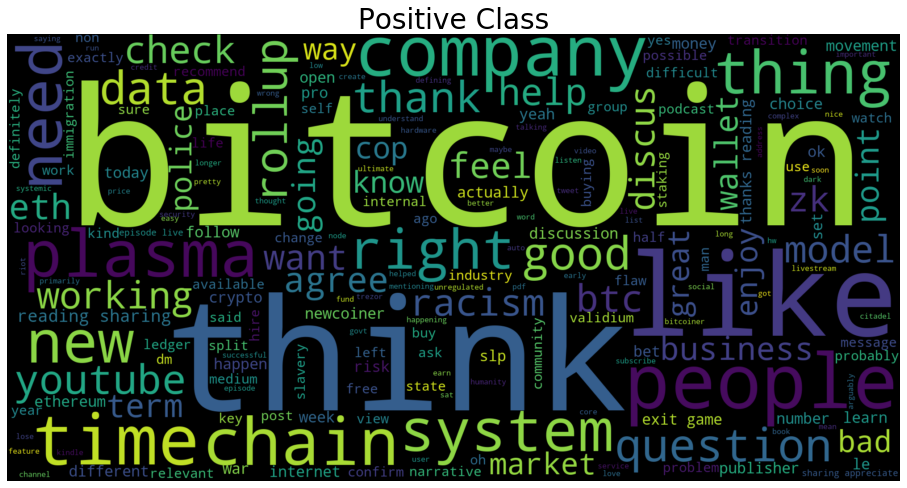

In [8]:
# wordcloud of positive class

Positive_class_text = (final_df.loc[final_df['target']==1][tweet_cols]).values

wordcloud = WordCloud(stopwords=all_stopwords,
                      width = 2000,
                      height=1000,
                      background_color="black").generate(str(Positive_class_text))

plt.figure(figsize=(16,9))
plt.title('Positive Class', fontsize= 28)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

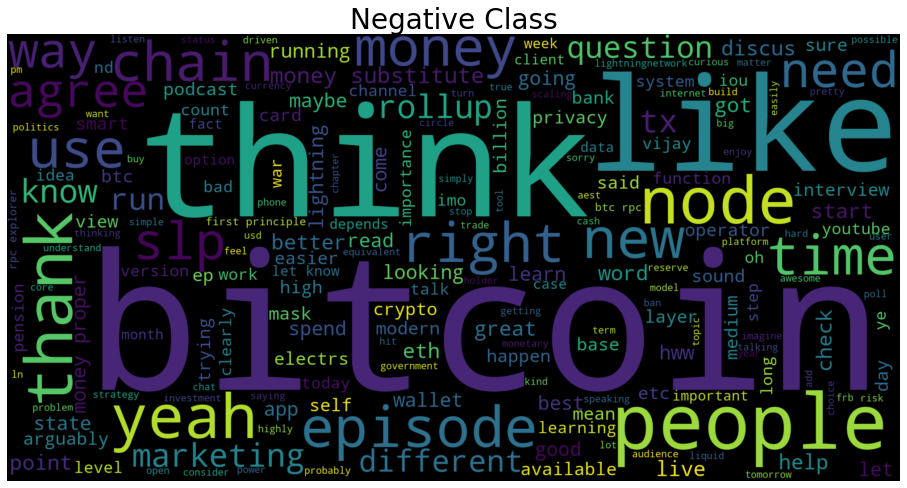

In [9]:
Negative_class_text = (final_df.loc[final_df['target']==0][tweet_cols]).values

wordcloud = WordCloud(stopwords=all_stopwords,
                      width = 2000,
                      height=1000,
                      background_color="black").generate(str(Negative_class_text))

plt.figure(figsize=(16,9))
plt.title('Negative Class', fontsize= 28)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

## Holdout Data

In [10]:
final_df.shape[0] * (4/5)

1022.4000000000001

In [11]:
final_df.shape

(1278, 28)

In [12]:
train = final_df.iloc[:1022]
test = final_df.iloc[1022:]

In [13]:
train.shape

(1022, 28)

In [14]:
test.shape

(256, 28)

In [15]:
train.to_csv('./datasets/train.csv')
test.to_csv('./datasets/test.csv')

## Train Test Spilt

In [16]:
# creating a column for all the tweets from influencers for that day

train['tweets_for_day'] = train[tweet_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
train[['tweets_for_day']].values

array([['everything taste mmmmmm poopic e oxioel going bean went standby reviewpic dp echtvux        thanks reminder add tried tell people right need tm fixed use segwit hard fork would cleaner happen time soon new new year mbga want understand bitcoin better epic list educational resource suggestion link welcome impossible predict future though shall see network could easily cause surge chain fee hm network first mover advantage right people hard soft fork main argument scale scale soft fork hard fork scale via either turn philosophical debate merit completely agree seems step forward better step general engineering problem across board devs need shove complexity hood felt way wallet library devs wrote support might well use lost count many people laughed bitcoin exceptionalism year ready yes seems practicality bitcoin far different traditional software want discussion jan sure innumerable theoretical way approach scaling focusing practicality wrote nearly year ago multiple possible a

In [18]:
test['tweets_for_day'] = test[tweet_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
test[['tweets_for_day']].values

array([['sure shame included list made banking medium kind badge honor like say either incentive drive world rarely regret betting provably false want learn fact bitcoin future finance subscribe letter send investor every morning want learn future finance sign email investor read every morning automation bitcoin investing going knowledge power   university malta launched blockchain specific master course one program around world report depends week close likely yes ru n  fiat money really property fiat money value rented central bank value taken back seized time reason bitcoin fix sunday survey primary o defi defiance keynote defi dapps day tel aviv common lightning app vulnerability multiple withdrawal payment stuck flight fee withdrawal malicious routing node collect high fee negative withdrawal amount floating point amount storing balance single value h tlc rgb meta scam enables scammer create crypto asset fast fungible pollute beloved timechain toxic waste tlc jxku jfcbf lightning 

In [20]:
train.drop(tweet_cols, inplace=True, axis=1)
test.drop(tweet_cols, inplace=True, axis=1)

/Users/johnsmith/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
train.shape

(1022, 11)

In [22]:
train.columns

Index(['open', 'high', 'low', 'close', 'volume', 'market_cap', 'date_stamp',
       'daily_price_diff', 'pct_change', 'target', 'tweets_for_day'],
      dtype='object')

In [23]:
from sklearn.model_selection import train_test_split

X = train['tweets_for_day']

# extract the labels from the train data
y = train.target.values

# use 70% for the training and 30% for the test
X_train, X_validate, y_train, y_validate = train_test_split(X, y,  
                                                    test_size=0.3, shuffle=False)

## Count Vectoriser

In [25]:
# vectorize tweets for model building
vectorizer = CountVectorizer(binary=True, stop_words='english')

# learn a vocabulary dictionary of all tokens in the raw documents
vectorizer.fit(list(X_train) + list(X_validate))

# transform documents to document-term matrix
X_train_vec = vectorizer.transform(X_train)
X_validate_vec = vectorizer.transform(X_validate)

In [27]:
X_train_vec.toarray().shape

(715, 50057)

In [29]:
X_validate_vec.toarray().shape

(307, 50057)

In [43]:
#Baseline Accuracy

np.bincount(y_train)

array([525, 190])

In [44]:
525/(525+190)

0.7342657342657343

In [30]:
from sklearn import svm
# classify using support vector classifier
svm = svm.SVC(kernel = 'linear', probability=True)

# fit the SVC model based on the given training data
prob = svm.fit(X_train_vec, y_train).predict_proba(X_validate_vec)

# perform classification and prediction on samples in x_test
y_pred_svm = svm.predict(X_validate_vec)

In [69]:
print("Train accuracy score for SVC is: ", svm.score(X_train_vec, y_train), '%')
print("Validate accuracy score for SVC is: ", accuracy_score(y_validate, y_pred_svm) * 100, '%')

Train accuracy score for SVC is:  1.0 %
Validate accuracy score for SVC is:  80.13029315960912 %


In [48]:
confusion_matrix(y_pred_svm, y_validate)

array([[242,  46],
       [ 15,   4]])

In [50]:
tn, fp, fn, tp = confusion_matrix(y_pred_svm, y_validate).ravel()

In [51]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 242
False Positives: 46
False Negatives: 15
True Positives: 4


In [53]:
# classify using XGBoost
CV_xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, 
                                 gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)

# fit the SVC model based on the given training data
prob = CV_xgb_model.fit(X_train_vec, y_train).predict_proba(X_validate_vec)

# perform classification and prediction on samples in x_test
y_pred_CV_xgb = CV_xgb_model.predict(X_validate_vec)

In [70]:
print("Train accuracy score for SVC is: ", CV_xgb_model.score(X_train_vec, y_train), '%')
print("Validate accuracy score for SVC is: ", accuracy_score(y_validate, y_pred_CV_xgb) * 100, '%')

Train accuracy score for SVC is:  0.9986013986013986 %
Validate accuracy score for SVC is:  83.71335504885994 %


In [72]:
confusion_matrix(y_pred=y_pred_CV_xgb,y_true=y_validate)

array([[257,   0],
       [ 50,   0]])

In [73]:
tn, fp, fn, tp = confusion_matrix(y_pred_CV_xgb, y_validate).ravel()

In [74]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 257
False Positives: 50
False Negatives: 0
True Positives: 0


In [75]:
# classify using support vector classifier
logreg = LogisticRegression()

# fit the SVC model based on the given training data
prob = logreg.fit(X_train_vec, y_train).predict_proba(X_validate_vec)

# perform classification and prediction on samples in x_test
y_pred_logreg = logreg.predict(X_validate_vec)

In [76]:
print("Train accuracy score for SVC is: ", logreg.score(X_train_vec, y_train), '%')
print("Validate accuracy score for SVC is: ", accuracy_score(y_validate, y_pred_logreg) * 100, '%')

Train accuracy score for SVC is:  1.0 %
Validate accuracy score for SVC is:  81.75895765472313 %


In [77]:
confusion_matrix(y_pred_logreg, y_validate)

array([[250,  49],
       [  7,   1]])

In [78]:
tn, fp, fn, tp = confusion_matrix(y_pred_logreg, y_validate).ravel()

In [79]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 250
False Positives: 49
False Negatives: 7
True Positives: 1


## Best model performance on the holdout dataset
Best model is XGboost

In [82]:
X = test['tweets_for_day']
y = test['target']

In [83]:
X_train_validate, X_holdout, y_train_validate, y_holdout = train_test_split(X,
                                                                            y,
                                                                            shuffle=False, 
                                                                            random_state=42, 
                                                                            test_size=0.2)

In [102]:
np.bincount(y_holdout)

array([44,  8])

In [103]:
#baseline accuracy

44/(44+8)

0.8461538461538461

In [90]:
# vectorize tweets for model building
vectorizer = CountVectorizer(binary=True, stop_words='english')

# learn a vocabulary dictionary of all tokens in the raw documents
vectorizer.fit(list(X_train_validate) + list(X_holdout))

# transform documents to document-term matrix
X_train_validate_vec = vectorizer.transform(X_train_validate)
X_holdout_vec = vectorizer.transform(X_holdout)

In [91]:
X_train_validate_vec.toarray().shape

(204, 25983)

In [92]:
X_holdout_vec.toarray().shape

(52, 25983)

In [95]:
CV_xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, 
                                 gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8)

# fit the SVC model based on the given training data
prob = CV_xgb_model.fit(X_train_validate_vec, y_train_validate).predict_proba(X_holdout_vec)

# perform classification and prediction on samples in x_test
y_pred_CV_xgb = CV_xgb_model.predict(X_holdout_vec)

In [97]:
print("Holdout accuracy score for SVC is: ", accuracy_score(y_holdout, y_pred_CV_xgb) * 100, '%')

Holdout accuracy score for SVC is:  84.61538461538461 %


In [98]:
confusion_matrix(y_pred_CV_xgb,y_holdout)

array([[44,  8],
       [ 0,  0]])

In [100]:
tn, fp, fn, tp = confusion_matrix(y_pred_CV_xgb, y_holdout).ravel()

In [101]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 44
False Positives: 8
False Negatives: 0
True Positives: 0
